In [108]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"

config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}

## Read the extracted features from the CSV

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Data used in SOA models

In [4]:
emotion_id_label = {
  0: "angry",
  1: "happy",
  2: "neutral",
  3: "sad",
}
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [61]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    table = [
        ["Accuracy", metrics.accuracy_score(y_labels, y_pred)],
        ["F1 score macro", metrics.f1_score(y_labels, y_pred, average='macro') ],
        ["F1 score micro", metrics.f1_score(y_labels, y_pred, average='micro') ],
        ["Precision", metrics.precision_score(y_labels, y_pred, average='macro') ],
        ["Recall", metrics.recall_score(y_labels, y_pred, average='macro') ],
        ["Hamming loss", metrics.hamming_loss(y_labels, y_pred)],
        ["Matthews corrcoef", metrics.matthews_corrcoef(y_labels, y_pred) ],
        ["Zero one loss", metrics.zero_one_loss(y_labels, y_pred)],
        ["Mean absolute error", metrics.mean_absolute_error(y_labels, y_pred)]
    ]
    print(tabulate(table, headers=["Metric","Value"]))

    if draw_corr_matrix:
        ticks =  ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix Real vs. Predicted Labels")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

# Categorical Problem (anger, happiness (+ excited), neutral, sadness)

## Models

### Simple Random Forests

In [62]:
def plot_cm_predictions(get_new_model, cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

Metric                  Value
-------------------  --------
Accuracy             0.587597
F1 score macro       0.595686
F1 score micro       0.587597
Precision            0.603754
Recall               0.591797
Hamming loss         0.412403
Matthews corrcoef    0.440989
Zero one loss        0.412403
Mean absolute error  0.648165


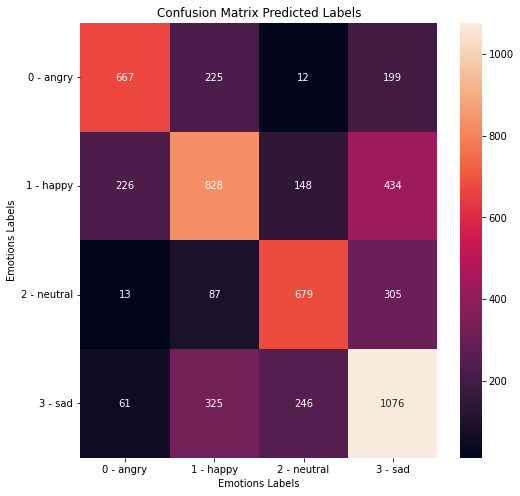

In [63]:
def get_new_model():
    return RandomForest(random_state=1, max_features=None)
plot_cm_predictions(get_new_model)

### AutoSKlearn

In [10]:
ensemble_model = AutoSklearnClassifier(
    max_models_on_disc=None,
    resampling_strategy='cv',
    resampling_strategy_arguments={'cv': {'folds': 5}},
    seed=1,
    n_jobs=-1
)
ensemble_model.fit(df.iloc[:, 8:].values, df.iloc[:, 4:5].values)

NameError: name 'AutoSklearnClassifier' is not defined

In [ ]:
import pickle
# save model
with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

# load model
with open('ensemble_model.pkl', 'rb') as f:
    ensemble_model = pickle.load(f)

In [ ]:
print(ensemble_model.sprint_statistics())

In [ ]:
ensemble_model.show_models()

In [ ]:
ensemble_model.leaderboard()

#### Testing the Ensemble Model from the Auto Keras

In [ ]:
def categorical_cross_validation(model, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    _, X_test = X.iloc[train], X.iloc[test]
    _, y_test = y.iloc[train], y.iloc[test]

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

categorical_cross_validation(ensemble_model)

#### Testing the Single Highest Ranked Model from the Auto Keras

Metric                  Value
-------------------  --------
Accuracy             0.6017
F1 score macro       0.609154
F1 score micro       0.6017
Precision            0.614036
Recall               0.606619
Hamming loss         0.3983
Matthews corrcoef    0.460297
Zero one loss        0.3983
Mean absolute error  0.623034


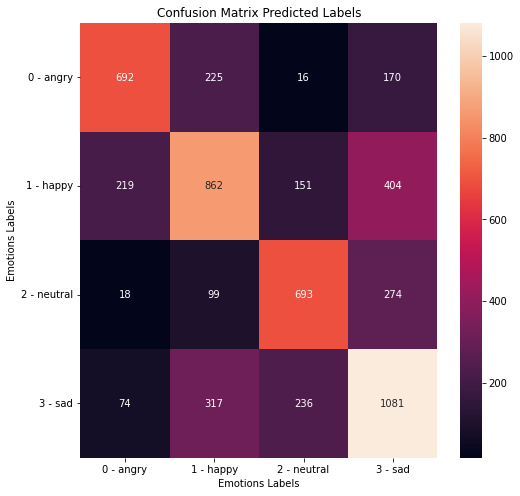

In [64]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=0,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)

plot_cm_predictions(get_new_model)

### Convolution Neural Networks

In [77]:
def build_model_0(input_shape=(24, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(24,1)).summary(show_trainable=True)

Model: "sequential_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_7 (Conv1D)           (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization_4 (Batc  (None, 20, 256)          1024      Y          
 hNormalization)                                                            
                                                                            
 activation_8 (Activation)   (None, 20, 256)           0         Y          
                                                                            
 conv1d_8 (Conv1D)           (None, 16, 128)           163968    Y          
                                                                            
 activation_9 (Activation)   (None, 16, 128)           0         Y          
                                                      

Metric                  Value
-------------------  --------
Accuracy             0.456156
F1 score macro       0.46223
F1 score micro       0.456156
Precision            0.485571
Recall               0.461326
Hamming loss         0.543844
Matthews corrcoef    0.264913
Zero one loss        0.543844
Mean absolute error  0.820286


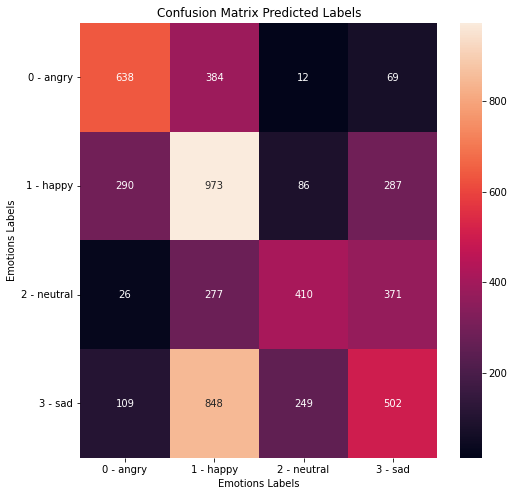

In [92]:
def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
  
  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    model = get_new_model(fold_no)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=8)

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500
batch_size = 16

verbosity = 0
num_folds = 5

def get_new_model(fold_no):
    learning_rate=1e-5
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_0(input_shape=(24, 1), loss=loss, optimizer=optimizer)

categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)

### AutoKeras

In [20]:
def categorical_cross_validation(get_new_model, no_epochs, batch_size, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = get_new_model(fold_no)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

no_epochs = 500
batch_size = 16

verbosity = 1
num_folds = 5

def get_new_model(fold_no):
    return ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"categorical_keras_model_fold_{fold_no}")
categorical_cross_validation(no_epochs, batch_size, verbosity, num_folds)

Trial 84 Complete [00h 00m 01s]
val_accuracy: 0.13287514448165894

Best val_accuracy So Far: 0.743413507938385
Total elapsed time: 00h 02m 26s
INFO:tensorflow:Oracle triggered exit


Epoch 1/500
277/277 [==============================] - 0s 707us/step - loss: 1.6184 - accuracy: 0.2493
Epoch 2/500
277/277 [==============================] - 0s 780us/step - loss: 1.6064 - accuracy: 0.2522
Epoch 3/500
277/277 [==============================] - 0s 776us/step - loss: 1.5952 - accuracy: 0.2592
Epoch 4/500
277/277 [==============================] - 0s 762us/step - loss: 1.5787 - accuracy: 0.2615
Epoch 5/500
277/277 [==============================] - 0s 718us/step - loss: 1.5554 - accuracy: 0.2712
Epoch 6/500
277/277 [==============================] - 0s 696us/step - loss: 1.5569 - accuracy: 0.2748
Epoch 7/500
277/277 [==============================] - 0s 696us/step - loss: 1.5372 - accuracy: 0.2843
Epoch 8/500
277/277 [==============================] - 0s 656us/step - loss: 1.5279 - accuracy: 0.2800
Epoch 9/500
277/277 [==============================] - 0s 653us/step - loss: 1.5341 - accuracy: 0.2793
Epoch 10/500
277/277 [==============================] - 0s 649us/step - l

#### Testing the Models

--------------------------Model of Fold 1 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.530645
F1 score macro       0.540567
F1 score micro       0.530645
Precision            0.551704
Recall               0.533673
Hamming loss         0.469355
Matthews corrcoef    0.361946
Zero one loss        0.469355
Mean absolute error  0.73296


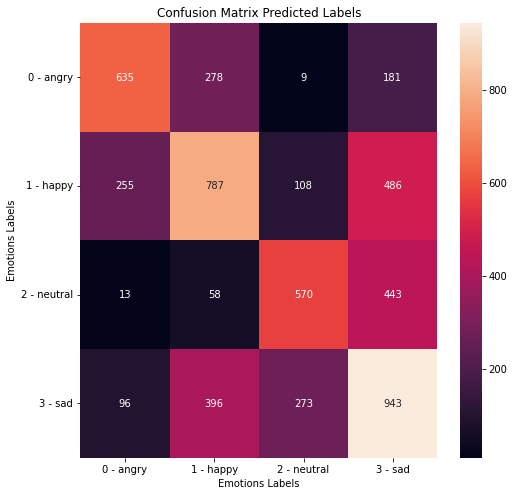

--------------------------Model of Fold 2 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.59501
F1 score macro       0.576292
F1 score micro       0.59501
Precision            0.677996
Recall               0.56057
Hamming loss         0.40499
Matthews corrcoef    0.449502
Zero one loss        0.40499
Mean absolute error  0.614175


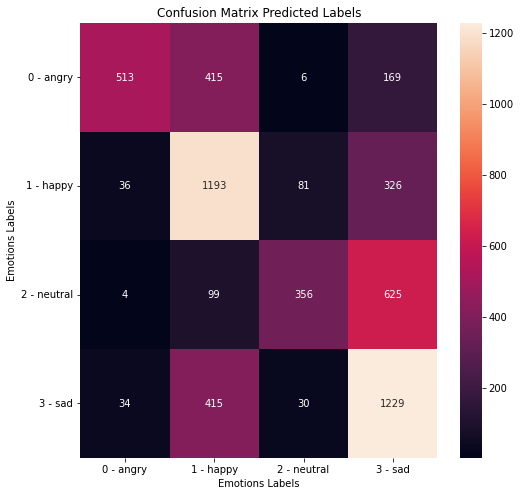

--------------------------Model of Fold 3 ----------------------------
Metric                    Value
-------------------  ----------
Accuracy              0.276803
F1 score macro        0.203536
F1 score micro        0.276803
Precision             0.226882
Recall                0.236248
Hamming loss          0.723197
Matthews corrcoef    -0.0232796
Zero one loss         0.723197
Mean absolute error   1.28819


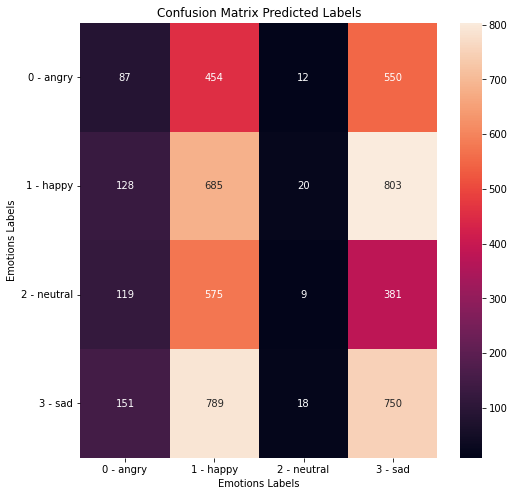

--------------------------Model of Fold 4 ----------------------------
Metric                    Value
-------------------  ----------
Accuracy              0.280419
F1 score macro        0.203063
F1 score micro        0.280419
Precision             0.225122
Recall                0.237781
Hamming loss          0.719581
Matthews corrcoef    -0.0197907
Zero one loss         0.719581
Mean absolute error   1.31983


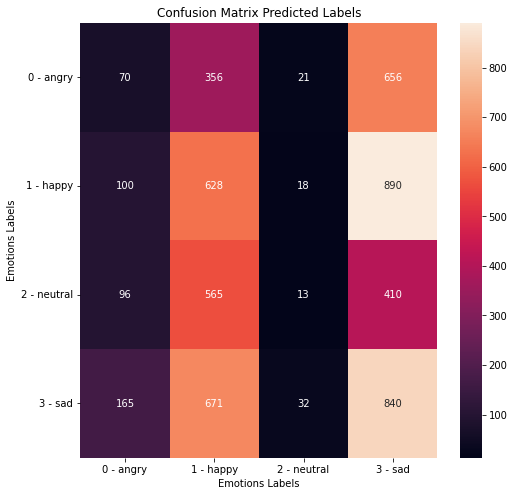

--------------------------Model of Fold 5 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.535708
F1 score macro       0.545431
F1 score micro       0.535708
Precision            0.557385
Recall               0.537914
Hamming loss         0.464292
Matthews corrcoef    0.368434
Zero one loss        0.464292
Mean absolute error  0.721931


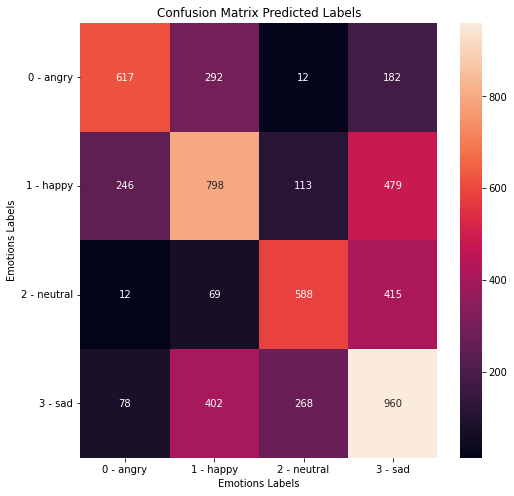

In [94]:
def categorical_cross_validation(model, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    _, X_test = X.iloc[train], X.iloc[test]
    _, y_test = y.iloc[train], y.iloc[test]

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

for i in range(1, 6):
    # for mac
    # model = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/categorical_keras_model_fold_{i}/structured_data_classifier/best_model"
    # for windows
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\categorical_keras_model_fold_{i}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    print(
        f'--------------------------Model of Fold {i} ----------------------------')
    categorical_cross_validation(model)


#### Highest Accuracy Model - Fold 2

In [95]:
tf.keras.models.load_model(f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\categorical_keras_model_fold_2\\structured_data_classifier\\best_model", custom_objects=ak.CUSTOM_OBJECTS).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 24)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               3200      
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                2064  

## Mel-Spectogram as the Input Feature

In [96]:
spec_df = pd.read_csv(RAW_AUDIO_FILES)
print(f"Number of Audio Files: {spec_df.shape[0]}")
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
spec_df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 10039


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [109]:
AUTOTUNE = tf.data.AUTOTUNE

def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for mac
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for mac
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]

def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [5024]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [5024]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


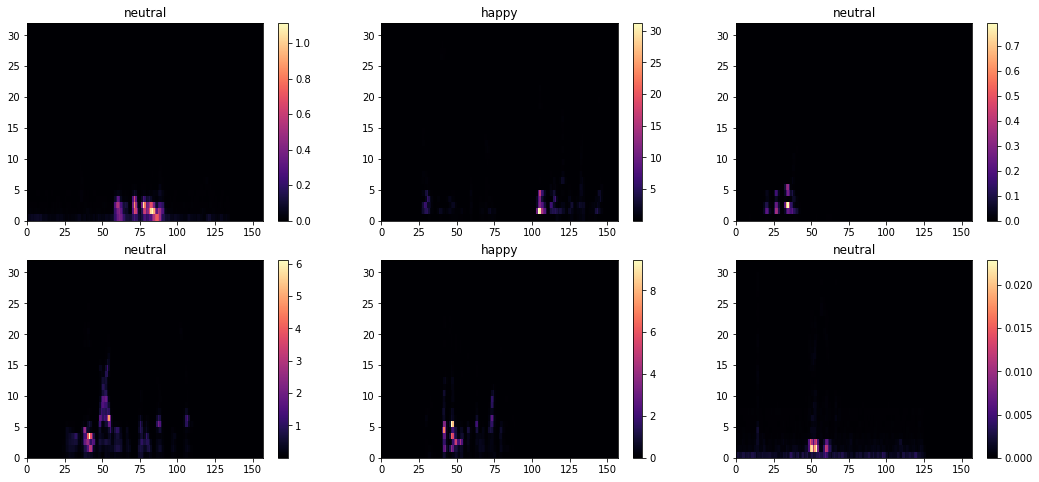

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, (audio, label) in enumerate(preprocess_dataset(spec_df).take(6)):
  r = i // 3
  c = i % 3
  ax = axes[r][c]
  spec = audio.numpy()
  spec = np.reshape(spec, (32, 157))
  im = ax.pcolormesh(spec, cmap="magma")
  fig.colorbar(im, ax=ax)
  label = label.numpy()[0]
  ax.set_title(emotion_id_label[label])

plt.show()

In [53]:
def categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = spec_df.iloc[:]
  y = spec_df.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=5, seed=1, directory=f"spec_categorical_keras_model_fold_{fold_no}")

    X_train, X_test = X.iloc[train], X.iloc[test]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    test_ds = preprocess_dataset(X_test)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback],
                workers=8)

    scores = model.evaluate(test_ds, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

no_epochs = 50
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 1
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds)

Trial 5 Complete [00h 11m 05s]
val_accuracy: 0.4788087010383606

Best val_accuracy So Far: 0.4868270456790924
Total elapsed time: 00h 40m 09s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
277/277 [==============================] - 40s 33ms/step - loss: 1.3261 - accuracy: 0.4115
Epoch 2/50
277/277 [==============================] - 10s 35ms/step - loss: 1.1403 - accuracy: 0.4929
Epoch 3/50
277/277 [==============================] - 10s 35ms/step - loss: 1.0132 - accuracy: 0.5356
Epoch 4/50
277/277 [==============================] - 10s 35ms/step - loss: 0.9337 - accuracy: 0.5821
Epoch 5/50
277/277 [==============================] - 10s 35ms/step - loss: 0.8624 - accuracy: 0.6185
Epoch 6/50
277/277 [==============================] - 10s 36ms/step - loss: 0.8161 - accuracy: 0.6411
Epoch 7/50
277/277 [==============================] - 10s 35ms/step - loss: 0.7769 - accuracy: 0.6642
Epoch 8/50
277/277 [==============================] - 10s 35ms/step - loss: 0.7425 - accuracy: 0.6818
Epoc

#### Testing the Models

--------------------------Model of Fold 1 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.702766
F1 score macro       0.697007
F1 score micro       0.702766
Precision            0.76722
Recall               0.681238
Hamming loss         0.297234
Matthews corrcoef    0.612225
Zero one loss        0.297234
Mean absolute error  0.464654


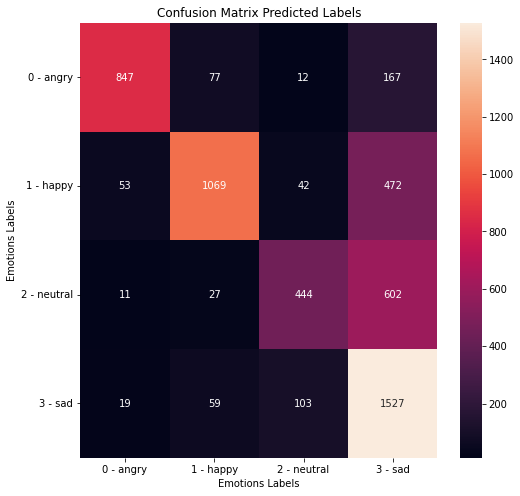

--------------------------Model of Fold 2 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.775086
F1 score macro       0.779366
F1 score micro       0.775086
Precision            0.784712
Recall               0.783579
Hamming loss         0.224914
Matthews corrcoef    0.70007
Zero one loss        0.224914
Mean absolute error  0.319834


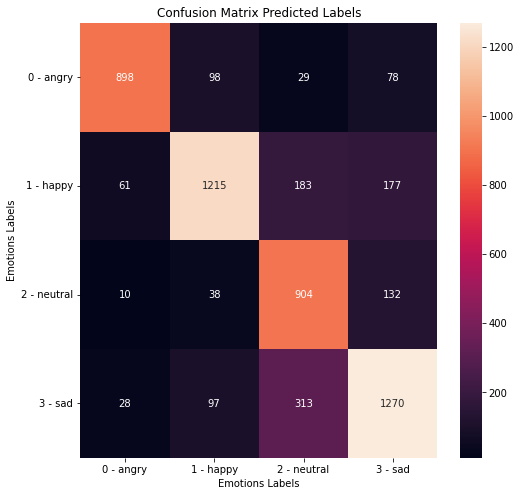

--------------------------Model of Fold 3 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.758091
F1 score macro       0.760487
F1 score micro       0.758091
Precision            0.765236
Recall               0.766385
Hamming loss         0.241909
Matthews corrcoef    0.677692
Zero one loss        0.241909
Mean absolute error  0.366118


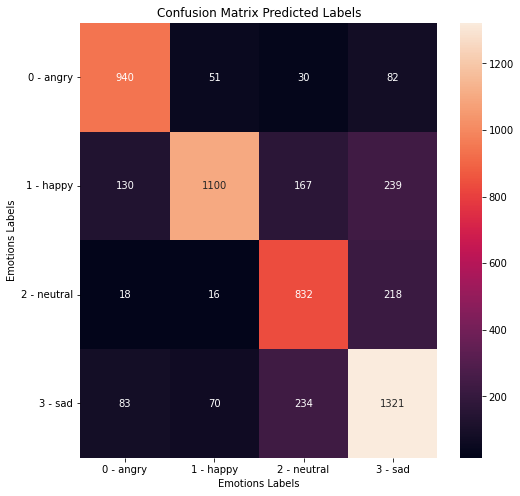

--------------------------Model of Fold 4 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.727174
F1 score macro       0.720845
F1 score micro       0.727174
Precision            0.788429
Recall               0.703851
Hamming loss         0.272826
Matthews corrcoef    0.644713
Zero one loss        0.272826
Mean absolute error  0.431568


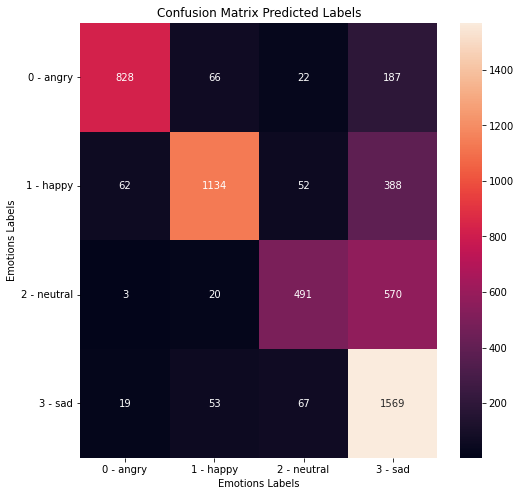

--------------------------Model of Fold 5 ----------------------------
Metric                  Value
-------------------  --------
Accuracy             0.772916
F1 score macro       0.776758
F1 score micro       0.772916
Precision            0.785358
Recall               0.774595
Hamming loss         0.227084
Matthews corrcoef    0.694877
Zero one loss        0.227084
Mean absolute error  0.333936


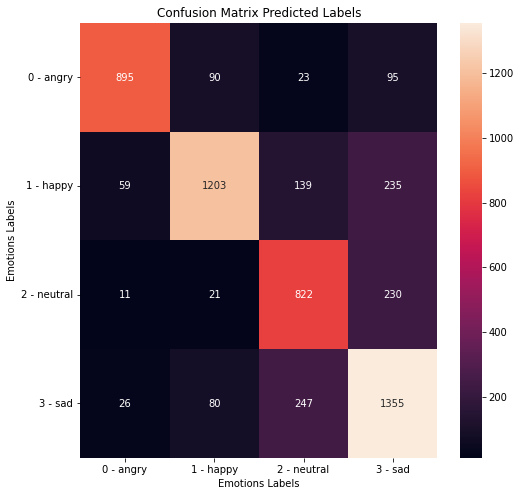

In [117]:
def categorical_cross_validation(model, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  all_y_pred = []
  all_y_labels = []
  fold_no = 1

  X = spec_df.iloc[:, ]
  y = spec_df.iloc[:, 4:5]

  for _, test in kfold.split(X, y):
    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

for i in range(1, 6):
  # for mac
  # model = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/spec_categorical_keras_model_fold_{i}/structured_data_classifier/best_model"
  # for windows
  model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\spec_categorical_keras_model_fold_{i}\\structured_data_classifier\\best_model"
  model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
  print(
      f'--------------------------Model of Fold {i} ----------------------------')
  categorical_cross_validation(model, 5)

#### Highest Accuracy Model

In [88]:
tf.keras.models.load_model(f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\spec_categorical_keras_model_fold_2\\structured_data_classifier\\best_model", custom_objects=ak.CUSTOM_OBJECTS).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5024)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 5024)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5024)             10049     
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                160800    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

## Mel-Spectogram as a Feature + Previous Selected Features